In [1]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.stats import entropy

# Assignment 3

## Generative Adversarial Networks on MNIST

In this assignment you will create and train a GAN to generate images of digits that mimic those in the MNIST dataset.

### Evaluation metric: Inception Score

Rather than just eye-balling whether GAN samples look good or not, researchers have come up with mulitple objective metrics for determining the quality and the diversity of GAN outputs. We will use one of the metrics called the *Inception Score*.

Calculating the Inception Score involves running a pretrained neural network. This is where the name is from: the authors who proposed this metric used a pretrained [Inception Network](https://arxiv.org/pdf/1409.4842.pdf) from Tensorflow in their [paper](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf). Since we will be using the MNIST dataset in this assignment, we provide a simpler neural work pretrained on MNIST as the scoring model.

The idea behind the Inception Score is simple: a good GAN should generate *meaningful* and *diverse* samples. For MNIST, a specific sample is "meaningful" if it looks like any of the 10 digits. When we take a good digit classifier and run it on this sample, it should assign high probability to one of the 10 classes and low probability to the others. In information theory terms, this means the predicted label distribution $p(y|x)$ for any specific sample $x$ should have high entropy. On the other hand, if the generated samples are diverse, they should be able to cover all 10 classes when we generate a large enough set of samples. This means that the "average" label distribution $p(y) = \int p(y|x=G(z)) \mathrm{d}z$ should have low entropy. The Inception Score is define by $\exp (\mathbb{E}_x \mathrm{KL}(p(y|x) || p(y)))$, where $\mathrm{KL}(P||Q)$ is the K-L divergence, which is often used to measure how probability distribution $P$ is different from distribution $Q$. Intuitively, if the generated samples are good, $p(y|x)$ should be different from $p(y)$, since one should have high entropy while the other should have low entropy.

Don't be too worried if you don't fully get how the score is defined and calculated. Just remember that in this assignment, we want our GAN to have a high Inception Score.

In [2]:
# Pretrained model used to evaluation the inception score.
class ScoringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
def inception_score_mnist(
    imgs,
    model_path='weights/mnist.ckpt',
    batch_size=32,
    num_splits=10,
):
    """Computes the inception score of `imgs`.
    
    Args:
    - imgs: Array of size (number of data points, 1, 28, 28)
    - batch_size: Batch size for feeding data into the pretrained MNIST model.
    - num_splits: Number of splits. We split the samples into multiple subsets
        and calculate the scores on each of them. Their mean is used as the
        final score.
    """
    # Verify that input arguments have the correct formats.
    assert type(imgs) == np.ndarray
    assert imgs.shape[1:] == (1, 28, 28)
    assert batch_size > 0
    assert len(imgs) > batch_size
    
    # Choose device to be used.
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # Preprocess input.
    imgs = copy.copy(imgs)
    imgs = (imgs - 0.1307) / 0.3081
    
    # Set up dataloader.
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load pretrained scoring model.
    model = ScoringModel()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get predictions.
    preds = []
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            logits = model(batch)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        preds.append(probs)
    preds = np.concatenate(preds)

    # Compute the mean KL divergence.
    split_scores = []

    for i in range(num_splits):
        n = len(imgs) // num_splits
        split = preds[i*n:(i+1)*n, :]
        py = np.mean(split, axis=0)
        scores = []
        for i in range(split.shape[0]):
            pyx = split[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

Now, let's try to calculate the Inception score on the actual MNIST dataset.

Make sure that the provided file `mnist.ckpt` is under `./weights`. Alternatively, you can specify its path via the `model_path` argument of `inception_score_mnist()`. If using Google Colab, click `View > Table of Contents > Files` and then upload it.

In [3]:
transform = torchvision.transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size=500, shuffle=True)

x, _ = next(iter(train_loader))
x = x.cpu().data.numpy()
x = x.reshape((-1,1,28,28))
print('Shape of data:',x.shape)
mean, std = inception_score_mnist(x)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 11832879.97it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28821245.26it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 10646482.87it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4553185.65it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Shape of data: (500, 1, 28, 28)


Inception Score: mean=9.273, std=0.320


The score for the real MNIST dataset should be above 8.


### Generating MNIST images (100 points)

As you did with the Gaussian distribution example in the weekly notebook, define and train a GAN to generate images that mimic those in the MNIST dataset.

#### Deliverables

- After training your model, generate at least 1500 samples using the trained generator, and evaluate your model by calculating the Inception score on the generated samples.
- Pick a few generated samples and visualize them.
- Plot the training losses for the discriminator and the generator.

Given the limited computational resources, you will want to achieve an Inception score of 1.5 or greater for full credits. A score of 1.5 won't yield great images. For nice looking images, you'll need an Inception score of around 6.0, but it is not needed for full credits.

#### Model Submission

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it easily. In this case, set `epochs = 0` and include the saved model in your submission (or a Google drive share link if its too large).

#### Tips

- It will be easier to get better results with a convolutional GAN. You may find this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) helpful. The generators of DCGANs make use of transposed convolutions (`nn.ConvTranspose2d` in PyTorch) to map features to larger sizes. This [article](https://d2l.ai/chapter_computer-vision/transposed-conv.html) does a good job illustrating how they work.
- Feel free to try different architectures, layers, optimizers, training schemes and other hyperparameters. Particularly, if training with one type of optimizer is slow or unstable, give other types of optimizers a try.

There are plenty of online resources about GAN that you can reference for inspiration. But do not plagiarize. Please write your own custom networks.

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])
Label: 5
first batch
torch.Size([100, 1, 28, 28])
tensor([7, 3, 2, 4, 6, 8, 1, 7, 3, 8, 8, 0, 8, 1, 9, 3, 0, 2, 7, 3, 4, 9, 4, 3,
        6, 4, 6, 0, 7, 5, 9, 2, 3, 8, 4, 0, 1, 6, 0, 8, 2, 4, 2, 1, 4, 7, 2, 1,
        3, 6, 1, 9, 1, 9, 7, 8, 7, 3, 9, 9, 5, 9, 2, 5, 0, 7, 0, 6, 2, 2, 3, 4,
        6, 2, 5, 1, 0, 9, 3, 3, 2, 1, 8, 7, 6, 5, 4, 8, 9, 0, 1, 6, 5, 9, 8, 3,
        7, 7, 6, 7])
Saving fake_images-0000.png
Epoch [0/5], Step [200/600], d_loss: 0.0450, g_loss: 4.1345, D(x): 0.99, D(G(z)): 0.04
Epoch [0/5], Step [400/600], d_loss: 0.0388, g_loss: 5.7798, D(x): 1.00, D(G(z)): 0.03
Epoch [0/5], Step [600/600], d_loss: 0.0495, g_loss: 4.9772, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0001.png


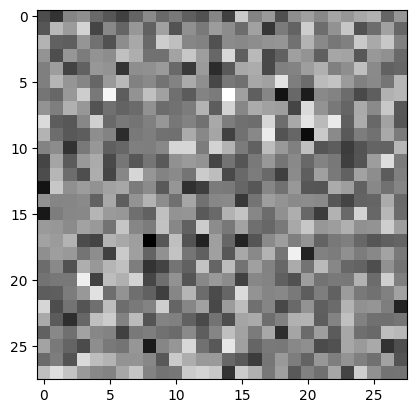

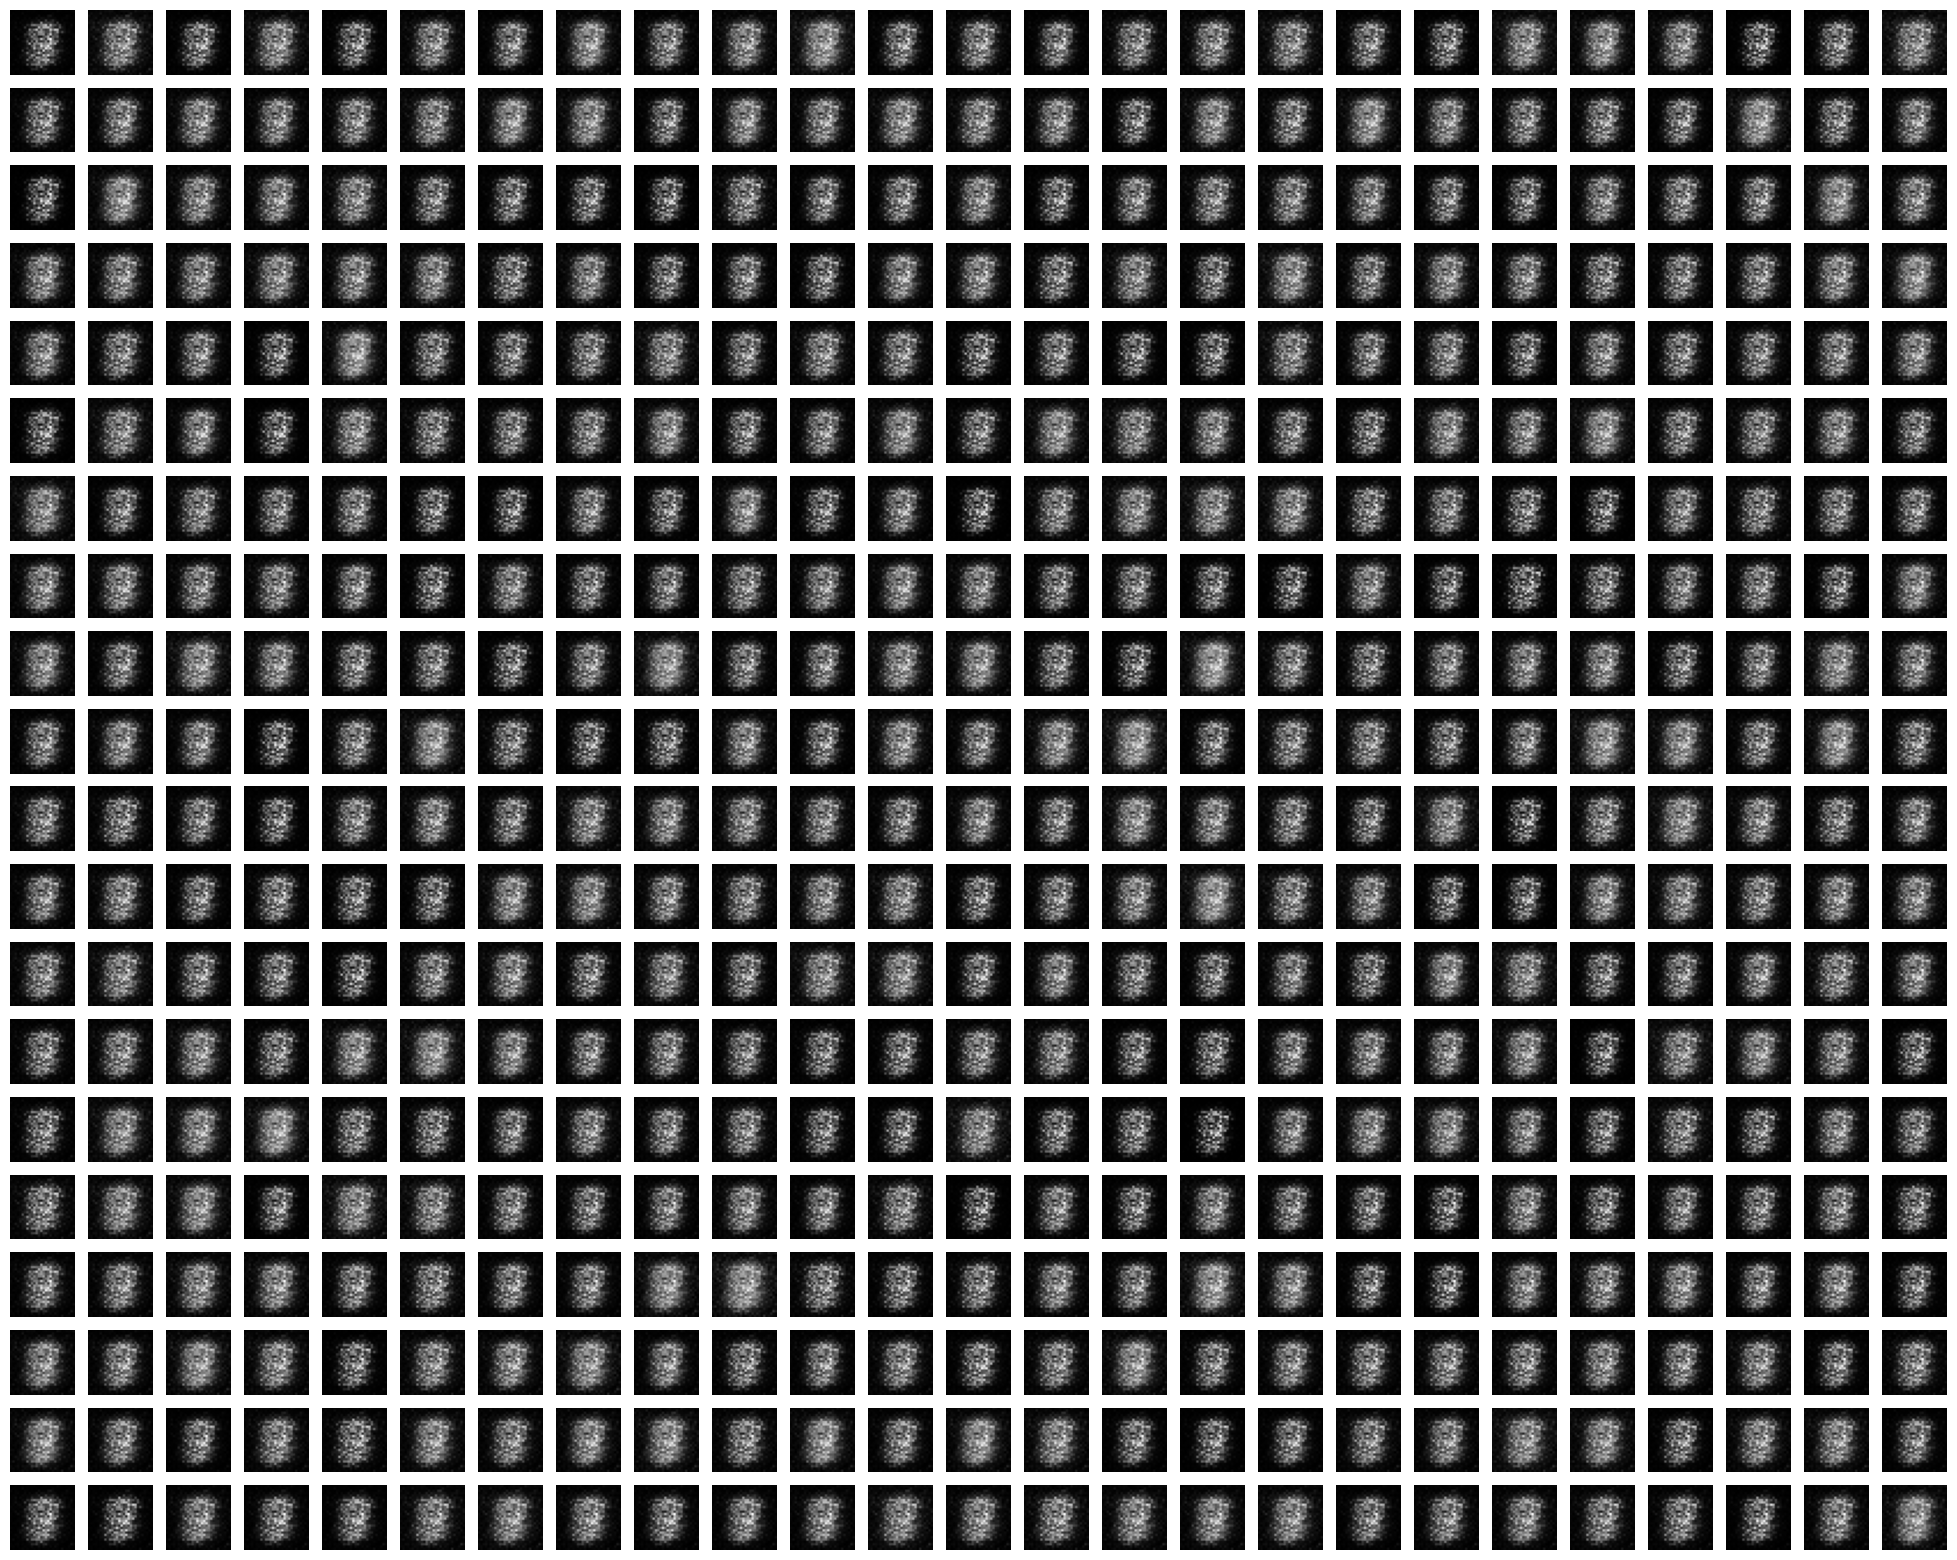

Shape of data: (500, 1, 28, 28)
Inception Score: mean=1.001, std=0.000


In [27]:
# Load the data
mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)

img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

plt.imshow(gen_imgs[0], cmap='gray');

plt.imshow(gen_imgs[1], cmap='gray');

G.to(device);

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

num_epochs = 5
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

#eh
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

y = G(torch.randn(500, 64).to(device))
y = y.detach().cpu()
gen_imgs = y.reshape((-1, 28,28)).unsqueeze(1).numpy()
# plt.imshow(gen_imgs[0], cmap='gray')
print(gen_imgs.shape)

fig, axes = plt.subplots(20, 25, figsize=(25, 20))
axes = axes.flatten()
for i in range(500):
    axes[i].imshow(gen_imgs[i][0], cmap='gray')  
    axes[i].axis('off') 

plt.show()


#gen_imgs = gen_imgs.reshape((-1,1,28,28)).numpy()
print('Shape of data:',gen_imgs.shape)
mean, std = inception_score_mnist(gen_imgs)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')